# Keras OCR

This is a slightly polished and packaged version of the Keras CRNN implementation and the published CRAFT text detection model. It provides a high level API for training a text detection and OCR pipeline.

In [ ]:
# !pip install keras-ocr
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


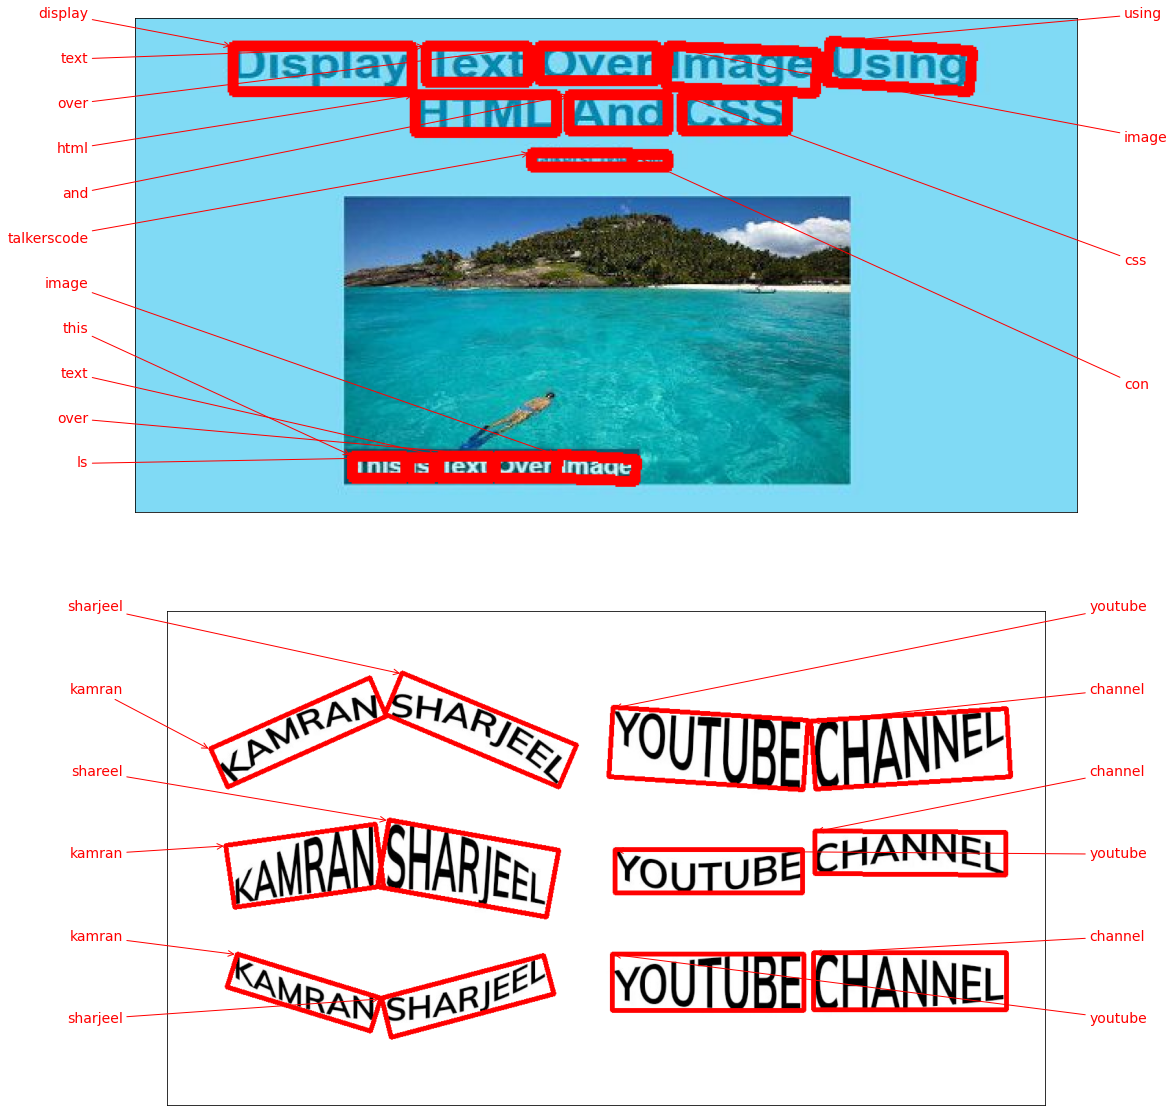

In [ ]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

# Get a set of three example images
images = [keras_ocr.tools.read(url) for url in [
'https://talkerscode.com/webtricks/images/text_over_image.jpg',
'https://i.ytimg.com/vi/fIVFH08ZPRE/maxresdefault.jpg']]

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
  keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

In [ ]:
import zipfile
import datetime
import string
import glob
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Generating synthetic data

First, we define the alphabet that encompasses all characters we want our model to be able to detect and recognize. Below we designate our alphabet as the numbers 0-9, upper- and lower-case letters, and a few puncuation marks. For the recognizer, we will actually only predict lowercase letters because we know some fonts print lower- and upper-case characters with the same glyph.

In order to train on synthetic data, we require a set of fonts and backgrounds. `keras-ocr` includes a set of both of these which have been downloaded from Google Fonts and Wikimedia. The code to generate both of these sets is available in the repository under `scripts/create_fonts_and_backgrounds.py`.

The fonts cover different languages which may have non-overlapping characters. `keras-ocr` supplies a function (`font_supports_alphabet`) to verify that a font includes the characters in an alphabet. We filter to only these fonts. We also exclude any fonts that are marked as `thin` in the filename because those tend to be difficult to render in a legible manner.

The backgrounds folder contains about just over 1,000 image backgrounds.

In [ ]:
alphabet = string.digits + string.ascii_letters + '!?. '
data_dir = '/root/.keras-ocr/data'
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for /root/.keras-ocr/fonts.zip
Unzipping fonts ZIP file.


Filtering fonts.: 100%|██████████| 2746/2746 [00:20<00:00, 132.02it/s]


Looking for /root/.keras-ocr/backgrounds.zip


With a set of fonts, backgrounds, and alphabet, we now build our data generators.

In order to create images, we need random strings. `keras-ocr` has a simple method for this for English, but anything that generates strings of characters in your selected alphabet will do!

The image generator generates `(image, lines)` tuples where `image` is a HxWx3 image and `lines` is a list of lines of text in the image where each line is itself a list of tuples of the form `((x1, y1), (x2, y2), (x3, y3), (x4, y4), c)`. `c` is the character in the line and `(x1, y2), (x2, y2), (x3, y3),
(x4, y4)` define the bounding coordinates in clockwise order starting from the top left. You can replace this with your own generator, just be sure to match that function signature.

We split our generators into train, validation, and test by separating the fonts and backgrounds used in each.


The first generated text is: Cromwell is Henning Pedersen
The first generated validation image (below) contains: The Blac
khawks Cl
ass V
I is th
e d
i


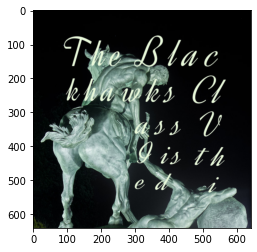

In [ ]:
text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

Here we build our detector and recognizer models. For both, we'll start with pretrained models. Note that for the recognizer, we freeze the weights in the backbone (all the layers except for the final classification layer).

In [ ]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan',
    # include_top=False
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


We are now ready to train our text detector. Below we use some simple defaults.

- Run training until we have no improvement on the validation set for 5 epochs.
- Save the best weights.
- For each epoch, iterate over all backgrounds one time.

The `detector` object has a `get_batch_generator` method which converts the `image_generator` (which returns images and associated annotations) into a `batch_generator` that returns `X, y` pairs for training with `fit_generator`.

If training on Colab and it assigns you a K80, you can only use batch size 1. But if you get a T4 or P100, you can use larger batch sizes.

In [ ]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit_generator(
    generator=detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=1,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size)
)

/usr/local/lib/python3.6/dist-packages/keras_ocr/tools.py:504: RuntimeWarning: invalid value encountered in float_scalars
  rotation = np.arctan((tl[0] - bl[0]) / (tl[1] - bl[1]))


827/827 [==============================] - 389s 471ms/step - loss: 0.0058 - val_loss: 0.0114


After training the text detector, we train the recognizer. Note that the recognizer expects images
to already be cropped to single lines of text. :code:`keras-ocr` provides a convenience method for
converting our existing generator into a single-line generator. So we perform that conversion.

This image contains: Se


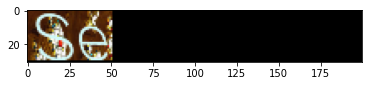

In [ ]:
max_length = 10
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

Just like the `detector`, the :code:`recognizer` has a method for converting the image generator
into a `batch_generator` that Keras' `fit_generator` can use.

We use the same callbacks for early stopping and logging as before.

In [ ]:
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recogntion_test_generator = [
    recognizer.get_batch_generator(
      image_generator=image_generator,
      batch_size=recognition_batch_size,
      lowercase=True
    ) for image_generator in recognition_image_generators
]
recognizer.training_model.fit_generator(
    generator=recognition_train_generator,
    epochs=1,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    callbacks=[
      tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
      tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
      tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    workers=0
)

104/104 [==============================] - 33s 319ms/step - loss: 20.0370 - val_loss: 11.7820


Once training is done, you can use `recognize` to extract text.

Actual: F a
t h e r i n l a
w   e x h u s b a
n d s   i t   r u l e
d   m a
n y
n a t i
o n s
i n   A Predicted: ['', '', 'n', '', '', '', '', '', '', '', '', '', '', '', '', 'o', '', '', '']


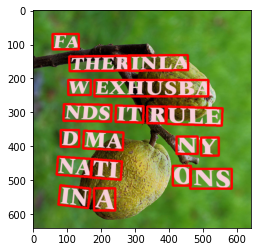

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)
image, lines = next(image_generators[0])
predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions])
plt.imshow(drawn)

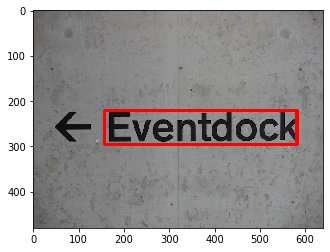

In [ ]:
# !curl https://raw.githubusercontent.com/faustomorales/keras-ocr/master/tests/test_image.jpg --output test_image.jpg
image = keras_ocr.tools.read('test_image.jpg')
boxes = detector.detect(images=[image])[0]
drawn = keras_ocr.detection.drawBoxes(image=image, boxes=boxes)
plt.imshow(drawn)

### References
- https://keras-ocr.readthedocs.io/_/downloads/en/stable/pdf/
- https://github.com/faustomorales/keras-ocr#egg=keras-ocr